# 경사하강법을 이용한 행렬 분해
- SVD(특이값 분해)는 NaN 값이 없는 행렬에만 적용할 수있다.
- 하지만 R 행렬(사용자 - 아이템 평점 행렬)은 아직 평점되지 않은 많은 Null 값이 존재하기 때문에 P와 Q행렬을 일반적인 SVD방식으로 분해할 수 없다.

## 실제 R행렬과 유사한 값을 갖는 R_hat행렬 계산
- R(m x n) = P(m x k) * Q.T(k x n) [m:유저수, n:아이템수, k:잠재요인 수]
    - R: 사용자-아이템 평점 행렬
    - P: 사용자-잠재요인 행렬 (초기값은 랜덤)
    - Q: 잠재요인-아이템 행렬 (초기값은 랜덤)
    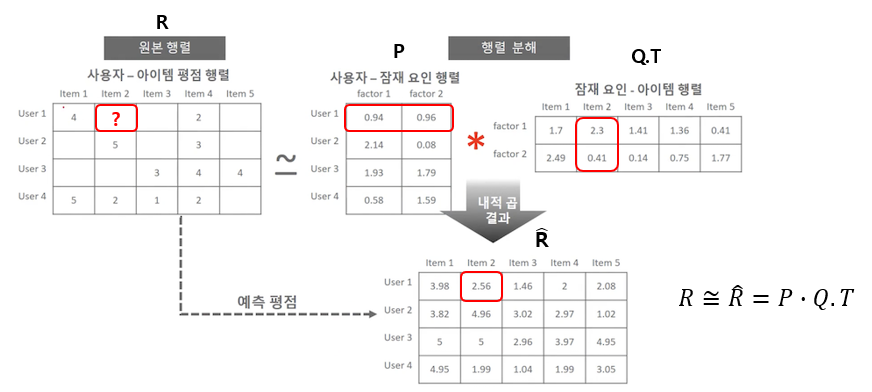

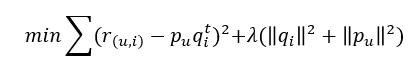
- 행렬 분해 함수 매개변수
    >- R: 사용자-아이템 평점 행렬
    >- k: 잠재요인 차원 수
    >- steps: 반복 학습 횟수
    >- learning_rate: 학습률
    >- r_lambda: L2규제 계수
    

In [2]:
import numpy as np
import pandas as pd

# 행렬분해 함수
def matrix_factorization(R, k, steps=200, learning_rate=0.01, r_lambda=0.01):
    num_users, num_items = R.shape
    
    np.random.seed(1)
    # scale=표준편차
    P = np.random.normal(scale=1./k, size=(num_users, k))
    Q = np.random.normal(scale=1./k, size=(num_items, k))
    
    # R > 0 인 행, 열 위치 그리고 값을 저장
    non_zeros = [(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]
    
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제값과 예측값의 차이인 오차를 구함
            eij = r - np.dot(P[i,:],Q[j,:].T)
            # L2 규제가 적용된 손실함수의 미분식
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j,:] - r_lambda * P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i,:] - r_lambda * Q[j,:])            
    return P, Q

### 경사하강법을 이용한 행렬분해 실습

In [5]:
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
             [np.NaN, 5, np.NaN, 3, 1],
             [np.NaN, np.NaN, 3, 4, 4],
             [5, 2, 1, 2, np.NaN]])
P, Q = matrix_factorization(R, k=10, steps=1000, learning_rate=0.01, r_lambda=0.01)
R_pred = np.dot(P, Q.T)
print(R)
print()
print(R_pred.round(2))

[[ 4. nan nan  2. nan]
 [nan  5. nan  3.  1.]
 [nan nan  3.  4.  4.]
 [ 5.  2.  1.  2. nan]]

[[3.99 2.31 0.92 2.   1.08]
 [5.64 4.98 0.84 2.99 1.  ]
 [4.58 2.26 2.99 3.98 3.98]
 [4.97 2.01 1.   2.   1.14]]


# 사용자-아이템 평점 행렬 변환

In [6]:
import pandas as pd

movies = pd.read_csv('datasets/movies.csv')
ratings = pd.read_csv('datasets/ratings.csv')
ratings = ratings.drop('timestamp', axis=1)

ratings_movies = pd.merge(ratings, movies)

ratings_matrix = ratings_movies.pivot_table(index='userId', columns='title', values='rating')
ratings_matrix = ratings_matrix.fillna(0)

ratings_matrix.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 경사하강법을 이용한 사용자-아이템 행렬 분해 및 예측 평점 행렬 생성
- R_hat = P * Q.T

In [7]:
P, Q = matrix_factorization(ratings_matrix.values, k=50, steps=200, learning_rate=0.01, r_lambda=0.01)
R_hat = np.dot(P, Q.T)

In [8]:
ratings_pred_matrix = pd.DataFrame(R_hat, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [15]:
ratings_pred_matrix['13th Warrior, The (1999)'][:1]

userId
1    3.906938
Name: 13th Warrior, The (1999), dtype: float64

# 평점을 주지 않은 영화 목록 반환

In [12]:
# ratings_matrix : 유저-아이템 행렬(DataFrame)
def get_unseen_movies(ratings_matrix, userId):
    # 모든 영화에 대한 한 유저의 평점 다 가져옴
    user_rating = ratings_matrix.loc[userId,:]
    # 한 유저가 관람하지 않은(평점이 0인) 영화 리스트 가져오기
    unseen_list = user_rating[user_rating == 0].index.values
    return unseen_list

# 특정 사용자의 관람하지 않은 영화에 대한 예측 평점 기반 추천

In [13]:
def recomm_movie_by_userId(pred_df, userId, unseen_list, top_n=10):
    # 한 유저가 보지 않은 영화에 대해서 평점 유사도가 높은 영화
    recomm_movies = pred_df.loc[userId,unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [14]:
unseen_list = get_unseen_movies(ratings_matrix, 9)
recomm_movies = recomm_movie_by_userId(ratings_pred_matrix, 9, unseen_list, 10)


recomm_movies = pd.DataFrame(recomm_movies.values, index=recomm_movies.index, columns=['pred score'])
recomm_movies

,pred score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690
